In [1]:
import os
import json, time, urllib.parse
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
pd.set_option('display.max_colwidth', None)

## Set workspace

In [2]:
start = time.time()
# CHANGE WORKING DIRECTORTY HERE
WD = '/Users/johnmichael/Documents/DATA512/data-512-homework_1'

## Import data

#### The Excel file 'thank_the_academy.AUG.2023.csv.xlsx' contains the full list of films we would like to pull page view data for.

In [3]:
titles = pd.read_excel(os.path.join(WD, 'input/thank_the_academy.AUG.2023.csv.xlsx'))

In [4]:
titles.head()

,name,url
0,Everything Everywhere All at Once,https://en.wikipedia.org/wiki/Everything_Everywhere_All_at_Once
1,All Quiet on the Western Front (2022 film),https://en.wikipedia.org/wiki/All_Quiet_on_the_Western_Front_(2022_film)
2,The Whale (2022 film),https://en.wikipedia.org/wiki/The_Whale_(2022_film)
3,Top Gun: Maverick,https://en.wikipedia.org/wiki/Top_Gun:_Maverick
4,Black Panther: Wakanda Forever,https://en.wikipedia.org/wiki/Black_Panther:_Wakanda_Forever


## Set global variables

#### The call to the Pageviews API will use the following global variables.

In [5]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<jmic94@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = list(titles.name)

DATE_START = '201507'
DATE_END = '202310'

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       DATE_START + "0100",   # start and end dates need to be set
    "end":         DATE_END + "0100"    # this is likely the wrong end date
}


## Helper function

#### The following function makes a request to the Pageviews API one article at a time.

In [6]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

## Pull pageview data

#### For mobile Pageviews, we have to pull mobile-app and mobile-web separately and combine these into one mobile data set later.

In [7]:
ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()
ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP['access'] = 'mobile-app'

ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()
ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB['access'] = 'mobile-web'

In [8]:
mobile_app_df = pd.DataFrame()
mobile_web_df = pd.DataFrame()
desktop_df = pd.DataFrame()

# Pull mobile-app data
for i, title in enumerate(ARTICLE_TITLES):
#     print(str(i) + ': ' + title)
    views = request_pageviews_per_article(
        title, request_template=ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP)
    df = pd.DataFrame(views['items'])
    mobile_app_df = pd.concat([mobile_app_df, df])

In [9]:
# Export data as csv
mobile_app_df.to_csv(
    os.path.join(WD, 'intermediate/mobile_app_data.csv'), index=False)

In [10]:
# Pull mobile-web data
for i, title in enumerate(ARTICLE_TITLES):
#     print(str(i) + ': ' + title)
    views = request_pageviews_per_article(
        title, request_template=ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB)
    df = pd.DataFrame(views['items'])
    mobile_web_df = pd.concat([mobile_web_df, df])

In [11]:
mobile_web_df.to_csv(
    os.path.join(WD, 'intermediate/mobile_web_data.csv'), index=False)

In [12]:
# Pull desktop data
for i, title in enumerate(ARTICLE_TITLES):
#     print(str(i) + ': ' + title)
    views = request_pageviews_per_article(
        title, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE)
    df = pd.DataFrame(views['items'])
    desktop_df = pd.concat([desktop_df, df])

In [13]:
desktop_df.to_csv(
    os.path.join(WD, 'intermediate/desktop_data.csv'), index=False)

## Create JSON datasets

In [14]:
monthly_mobile = pd.concat([mobile_app_df, mobile_web_df])
# Sum up mobile-app and mobile-web views per article and month
monthly_mobile = monthly_mobile.groupby(
    ['project', 'article', 'granularity',
     'timestamp', 'agent'])['views'].sum().reset_index()
filename = 'academy_monthly_mobile_' + DATE_START + '-' + DATE_END + '.json'
key_column = 'article'
grouped_data = monthly_mobile.groupby(key_column).apply(
    lambda x: x.drop(key_column, axis=1).to_dict(orient='records')).to_dict()
with open(os.path.join(WD, 'output', filename), 'w') as json_file:
    json.dump(grouped_data, json_file, indent=4)

In [15]:
monthly_desktop = desktop_df.groupby(
    ['project', 'article', 'granularity',
     'timestamp', 'agent'])['views'].sum().reset_index()
filename = 'academy_monthly_desktop_' + DATE_START + '-' + DATE_END + '.json'
grouped_data = monthly_desktop.groupby(key_column).apply(
    lambda x: x.drop(key_column, axis=1).to_dict(orient='records')).to_dict()
with open(os.path.join(WD, 'output', filename), 'w') as json_file:
    json.dump(grouped_data, json_file, indent=4)

#### To get cumulative monthly views per article, we first combine the three data sets (mobile-app, mobile-web, desktop). Then, sort by month before calculating the cumulative for each article.

In [16]:
monthly_all = pd.concat([mobile_app_df, mobile_web_df, desktop_df])
monthly_all.sort_values(['article', 'timestamp'], inplace=True)
monthly_all = monthly_all.groupby(
    ['project', 'article', 'granularity',
     'timestamp', 'agent']).sum('views').reset_index()
monthly_all['cumulative_views'] = monthly_all.groupby('article')['views'].cumsum()
filename = 'academy_monthly_cumulative_' + DATE_START + '-' + DATE_END + '.json'
grouped_data = monthly_all.groupby(key_column).apply(
    lambda x: x.drop(key_column, axis=1).to_dict(orient='records')).to_dict()
with open(os.path.join(WD, 'output', filename), 'w') as json_file:
    json.dump(grouped_data, json_file, indent=4)

## Visualizations

#### Calculate the average montly views for mobile and desktop. Then, combine the two results into a single dataframe before making the time series plot using Matplotlib and Seaborn.

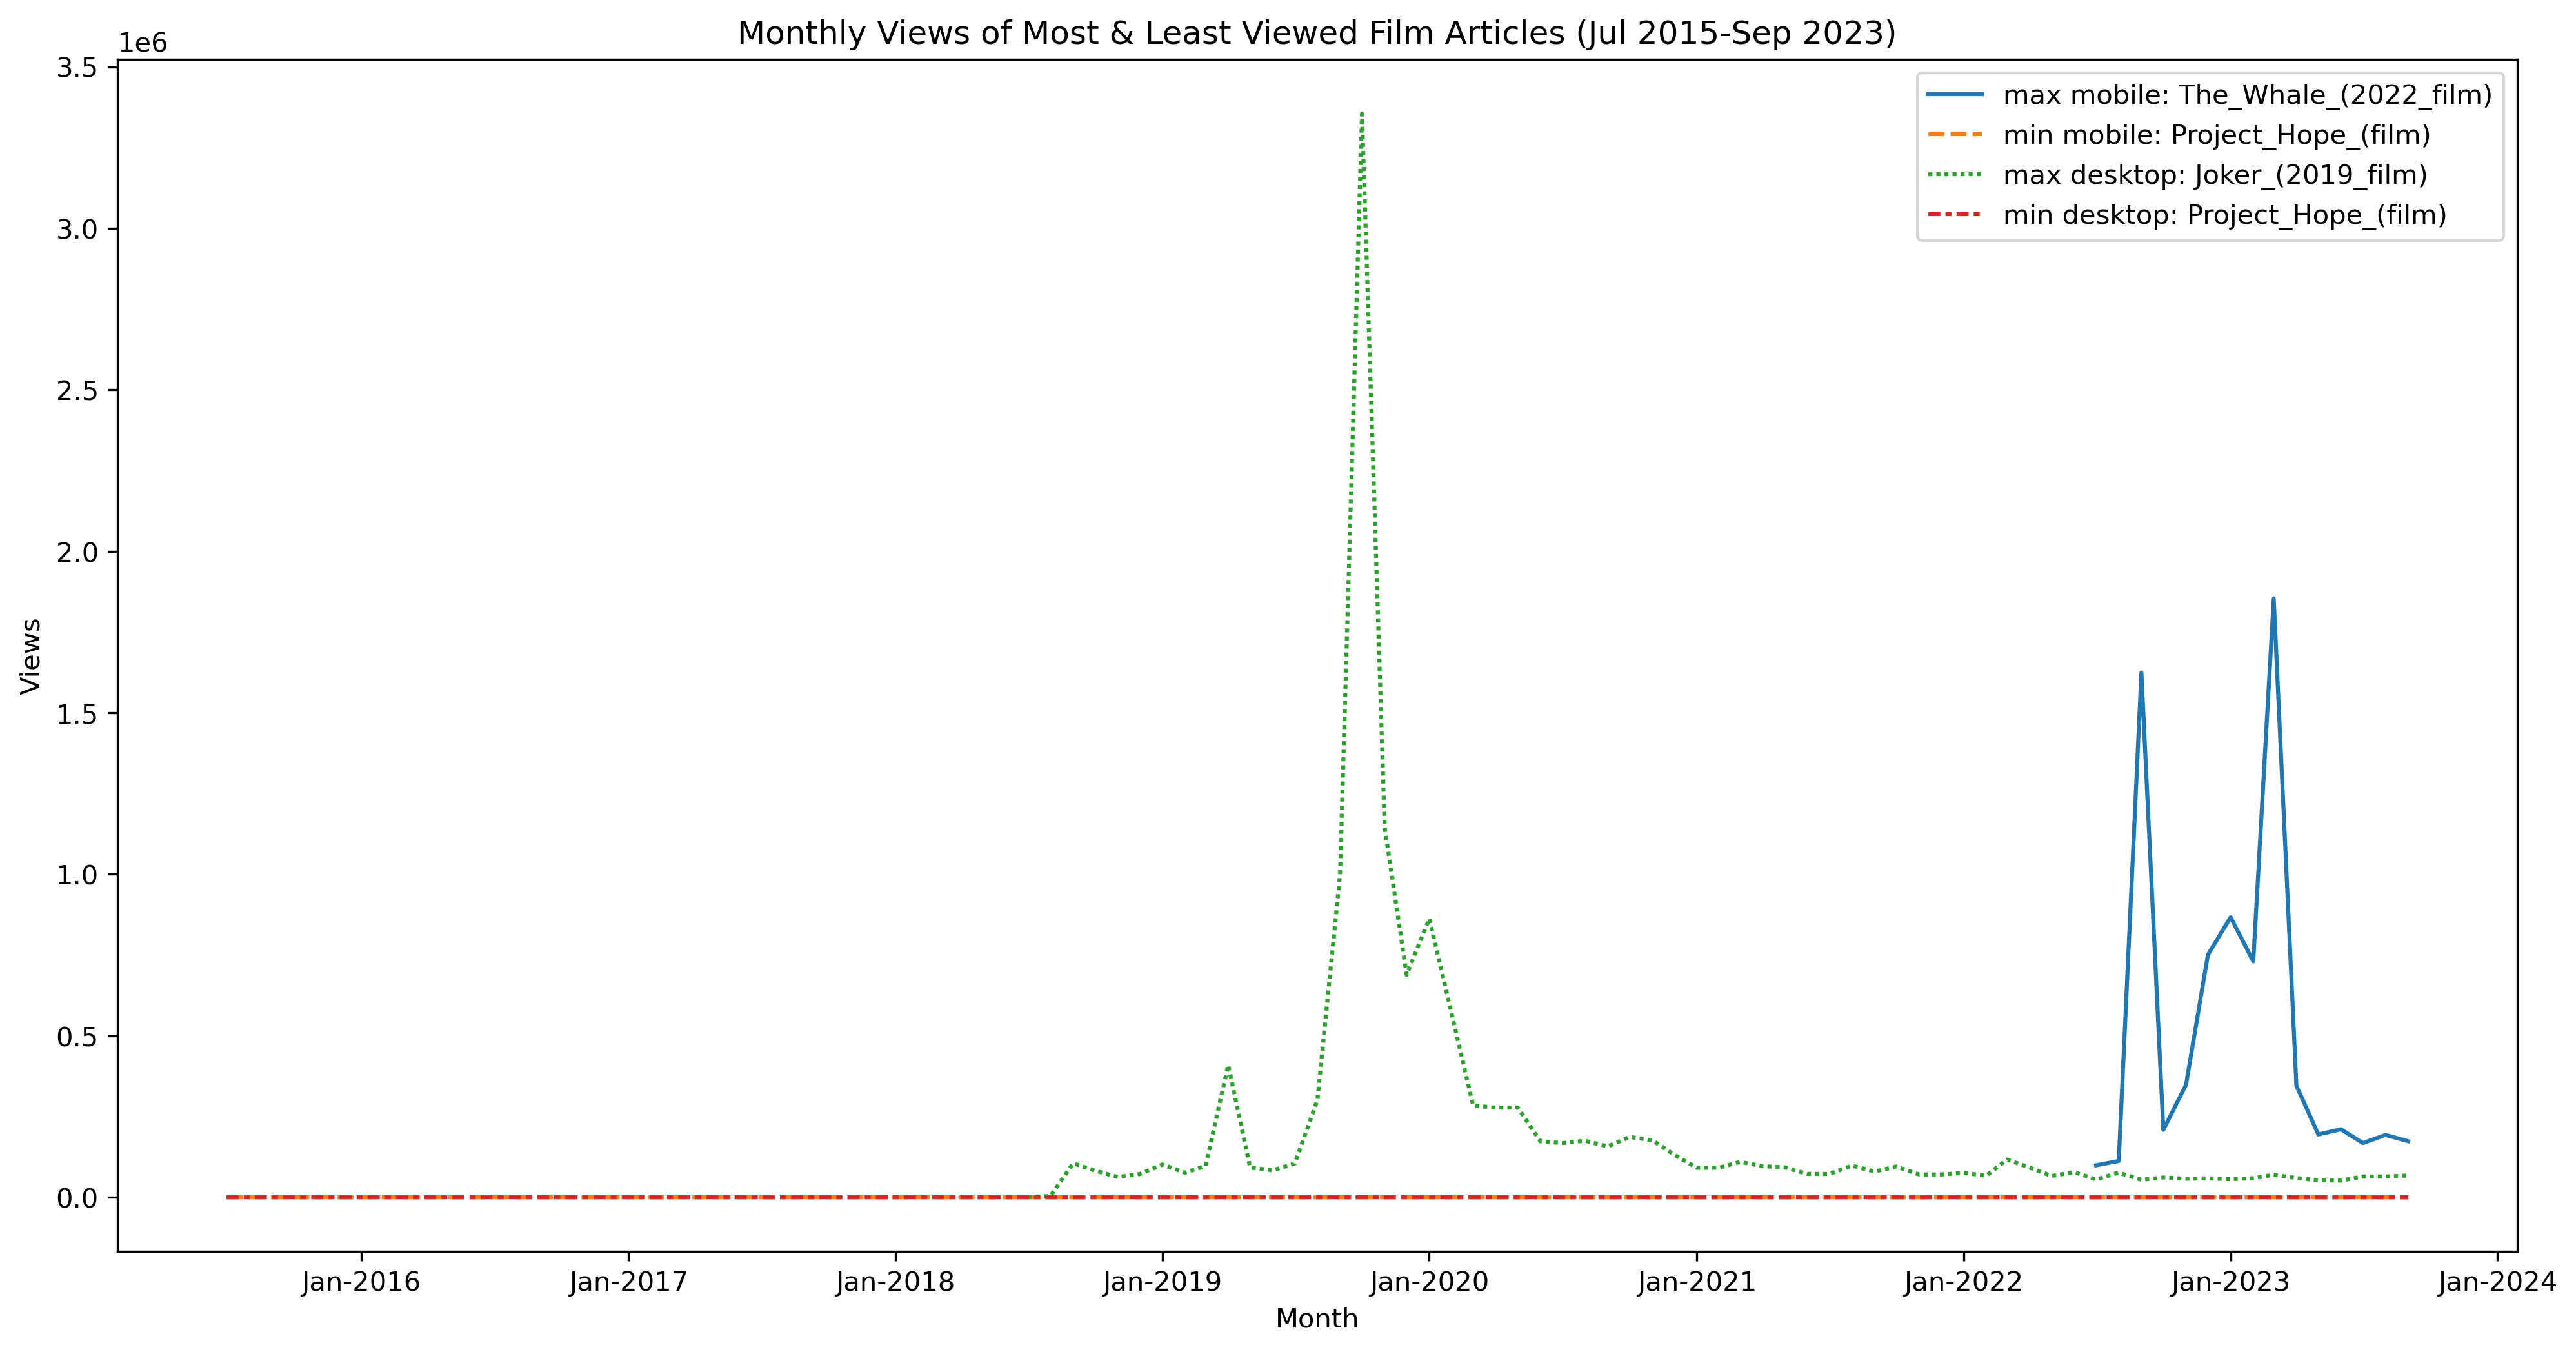

In [17]:
monthly_average_mobile = monthly_mobile.groupby('article').mean('views').reset_index()
monthly_average_mobile.sort_values('views', ascending=False, inplace=True)
max_avg_mobile = monthly_average_mobile.article.values[0]
min_avg_mobile = monthly_average_mobile.article.values[-1]

monthly_average_desktop = monthly_desktop.groupby('article').mean('views').reset_index()
monthly_average_desktop.sort_values('views', ascending=False, inplace=True)
max_avg_desktop = monthly_average_desktop.article.values[0]
min_avg_desktop = monthly_average_desktop.article.values[-1]

max_mobile_df = monthly_mobile[monthly_mobile.article == max_avg_mobile].copy()
max_mobile_df['label'] = 'max mobile'
min_mobile_df = monthly_mobile[monthly_mobile.article == min_avg_mobile].copy()
min_mobile_df['label'] = 'min mobile'
max_desktop_df = monthly_desktop[monthly_desktop.article == max_avg_desktop].copy()
max_desktop_df['label'] = 'max desktop'
min_desktop_df = monthly_desktop[monthly_desktop.article == min_avg_desktop].copy()
min_desktop_df['label'] = 'min desktop'

avg_df = pd.concat([max_mobile_df, min_mobile_df,
                    max_desktop_df, min_desktop_df])
avg_df['month'] = avg_df.timestamp.str[:8]
avg_df['month'] = pd.to_datetime(avg_df.month)
avg_df['label'] = avg_df['label'] + ': ' + avg_df['article']

plt.figure(figsize=(16, 8), dpi=300)
sns.lineplot(data=avg_df, x='month', y='views', hue='label', style='label')
date_format = mdates.DateFormatter('%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel('Month')
plt.ylabel('Views')
plt.title('Monthly Views of Most & Least Viewed Film Articles (Jul 2015-Sep 2023)')
plt.legend(title='')
plt.savefig(os.path.join(WD, 'output/max_min_avg.png'))

#### Calculate the peak months first and then sort by the peak views. Select the top 10. Do this for mobile and desktop before combining to create the time series plot.

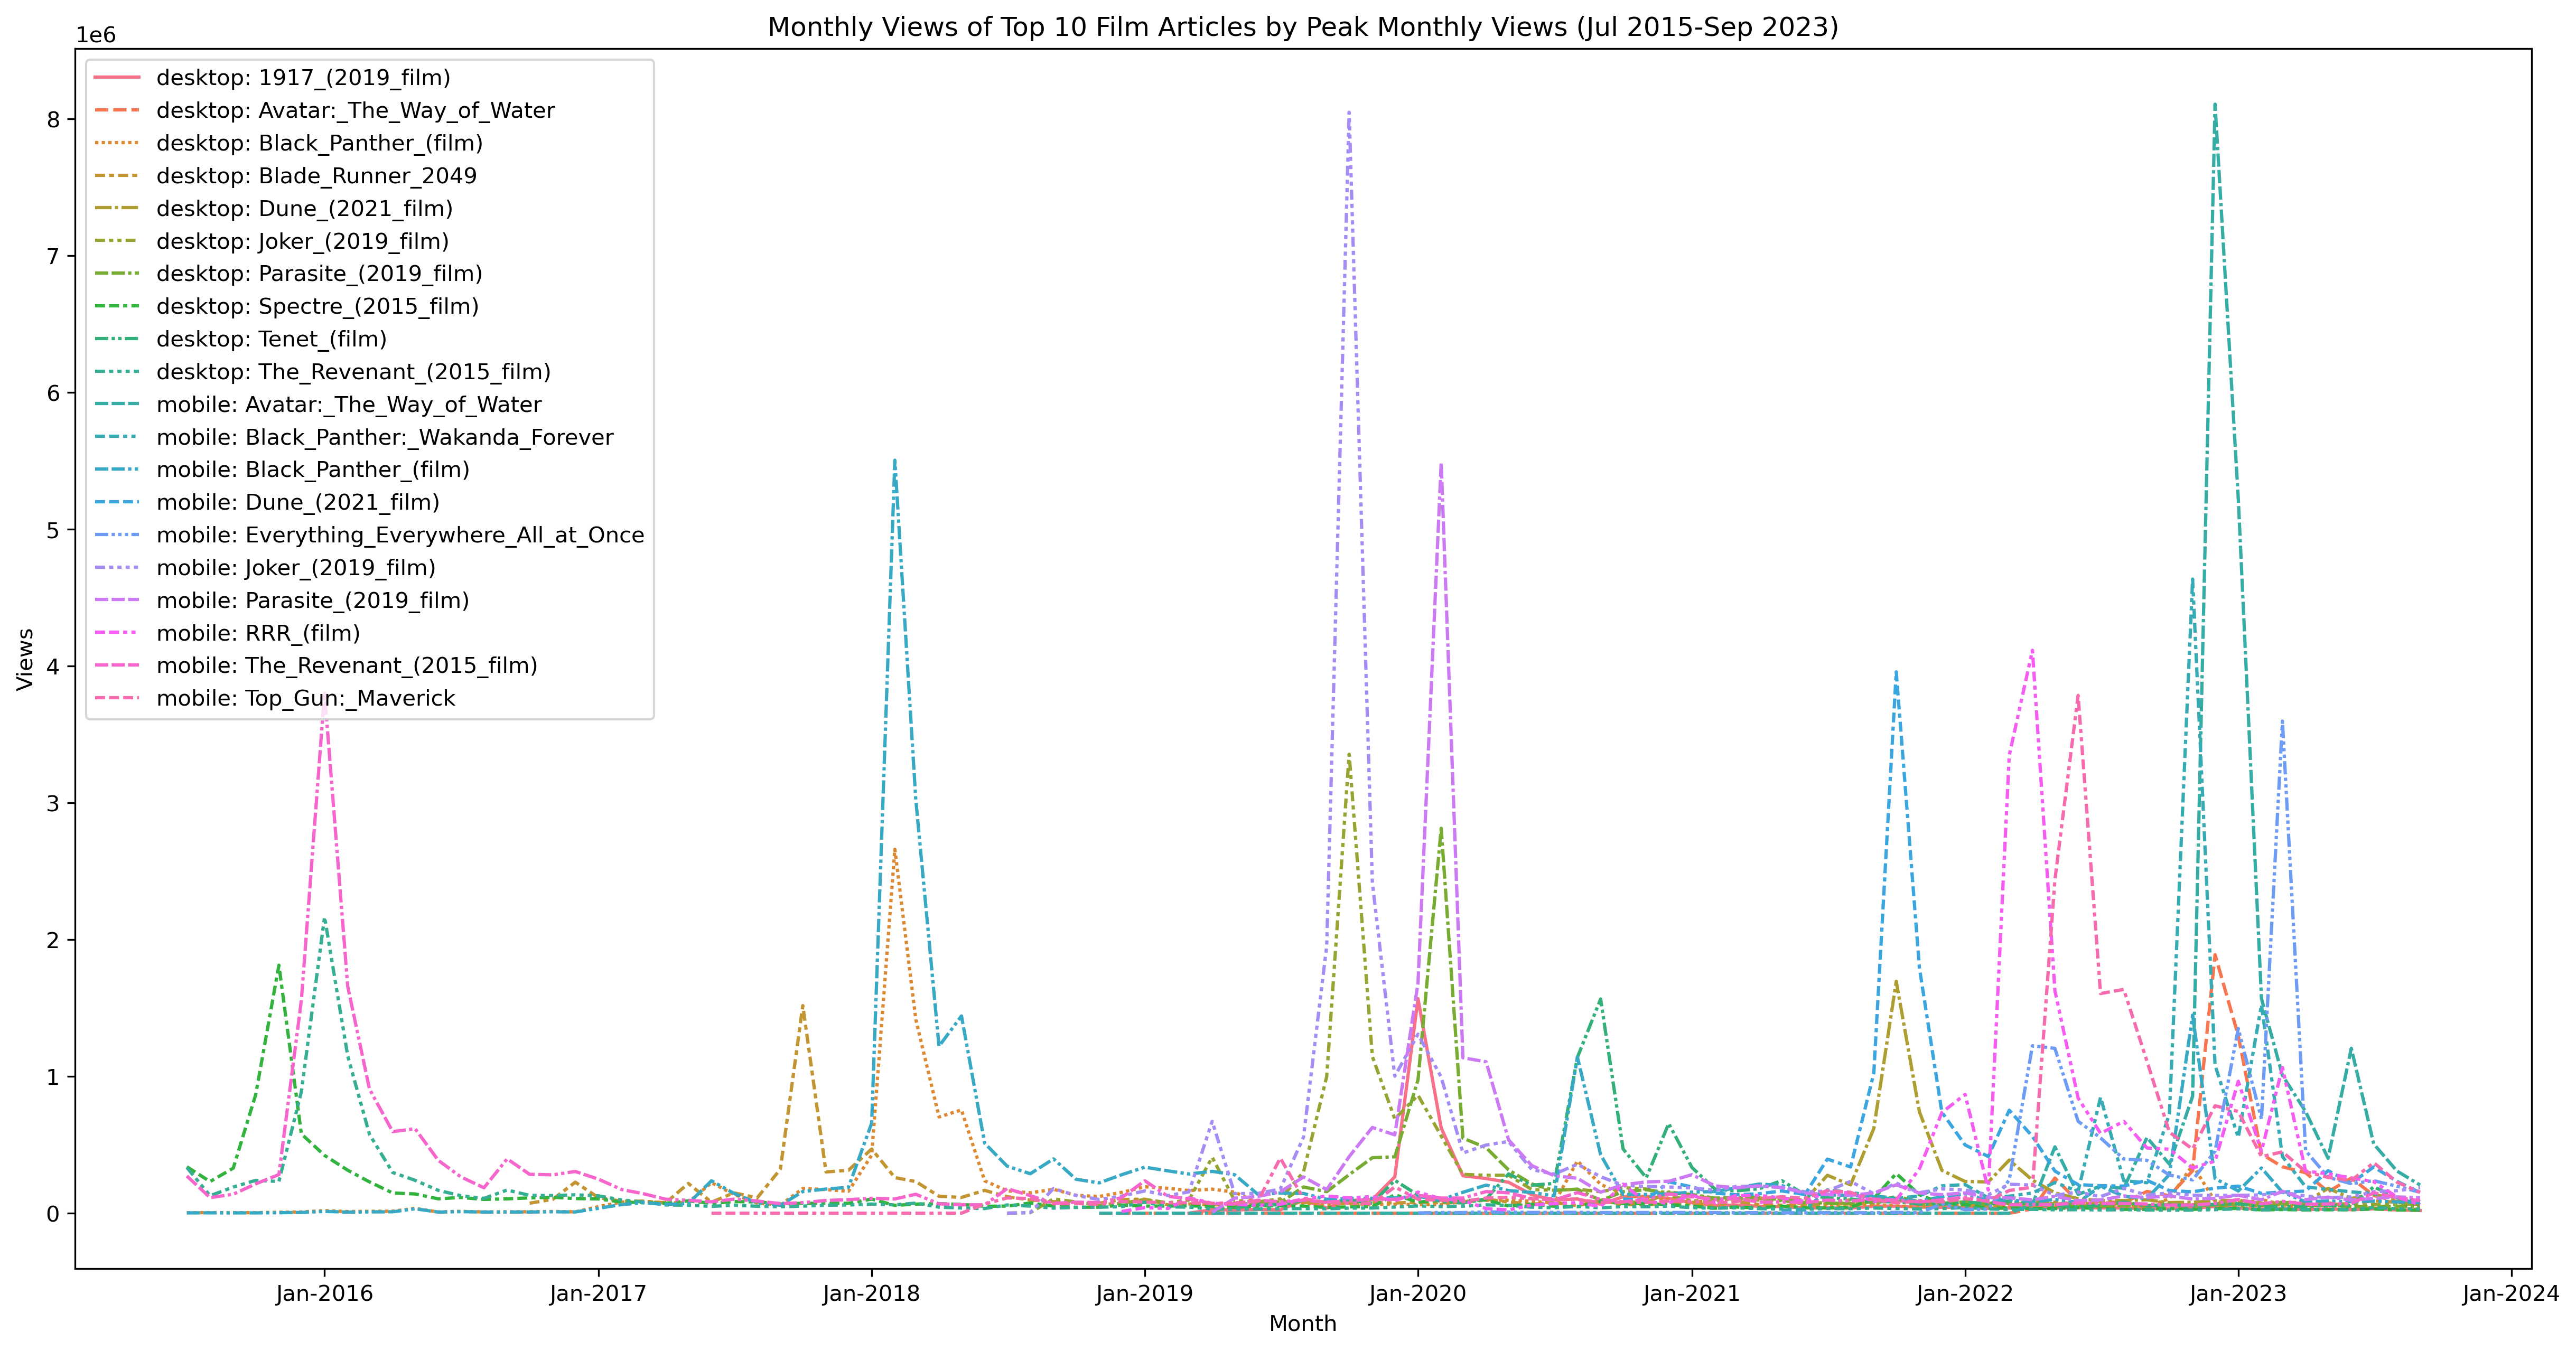

In [18]:
max_months_mobile = monthly_mobile.groupby('article')['views'].max().reset_index()
max_months_mobile.sort_values('views', ascending=False, inplace=True)
max_months_mobile = max_months_mobile.head(10)
top_10_peaks_mobile = monthly_mobile[
    monthly_mobile['article'].isin(max_months_mobile.article)].copy()
top_10_peaks_mobile['label'] = 'mobile'

max_months_desktop = monthly_desktop.groupby('article')['views'].max().reset_index()
max_months_desktop.sort_values('views', ascending=False, inplace=True)
max_months_desktop = max_months_desktop.head(10)
top_10_peaks_desktop = monthly_desktop[
    monthly_desktop['article'].isin(max_months_desktop.article)].copy()
top_10_peaks_desktop['label'] = 'desktop'

top_10_peaks = pd.concat([top_10_peaks_desktop, top_10_peaks_mobile])
top_10_peaks['month'] = top_10_peaks.timestamp.str[:8]
top_10_peaks['month'] = pd.to_datetime(top_10_peaks.month)
top_10_peaks['label'] = top_10_peaks['label'] + ': ' + top_10_peaks['article']
top_10_peaks.sort_values(['label'], inplace=True)

plt.figure(figsize=(20, 10), dpi=300)
sns.lineplot(data=top_10_peaks, x='month', y='views', hue='label', style='label')
date_format = mdates.DateFormatter('%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.xlabel('Month')
plt.ylabel('Views')
plt.title('Monthly Views of Top 10 Film Articles by Peak Monthly Views (Jul 2015-Sep 2023)')
plt.legend(title='')
plt.savefig(os.path.join(WD, 'output/top_10_peaks.png'))

#### Count the number of months per article. Sort by ascending order of the number of available months. Select the 10 articles with the fewest number of months available. Do this for mobile and desktop separately before combining them into one dataframe for plotting.

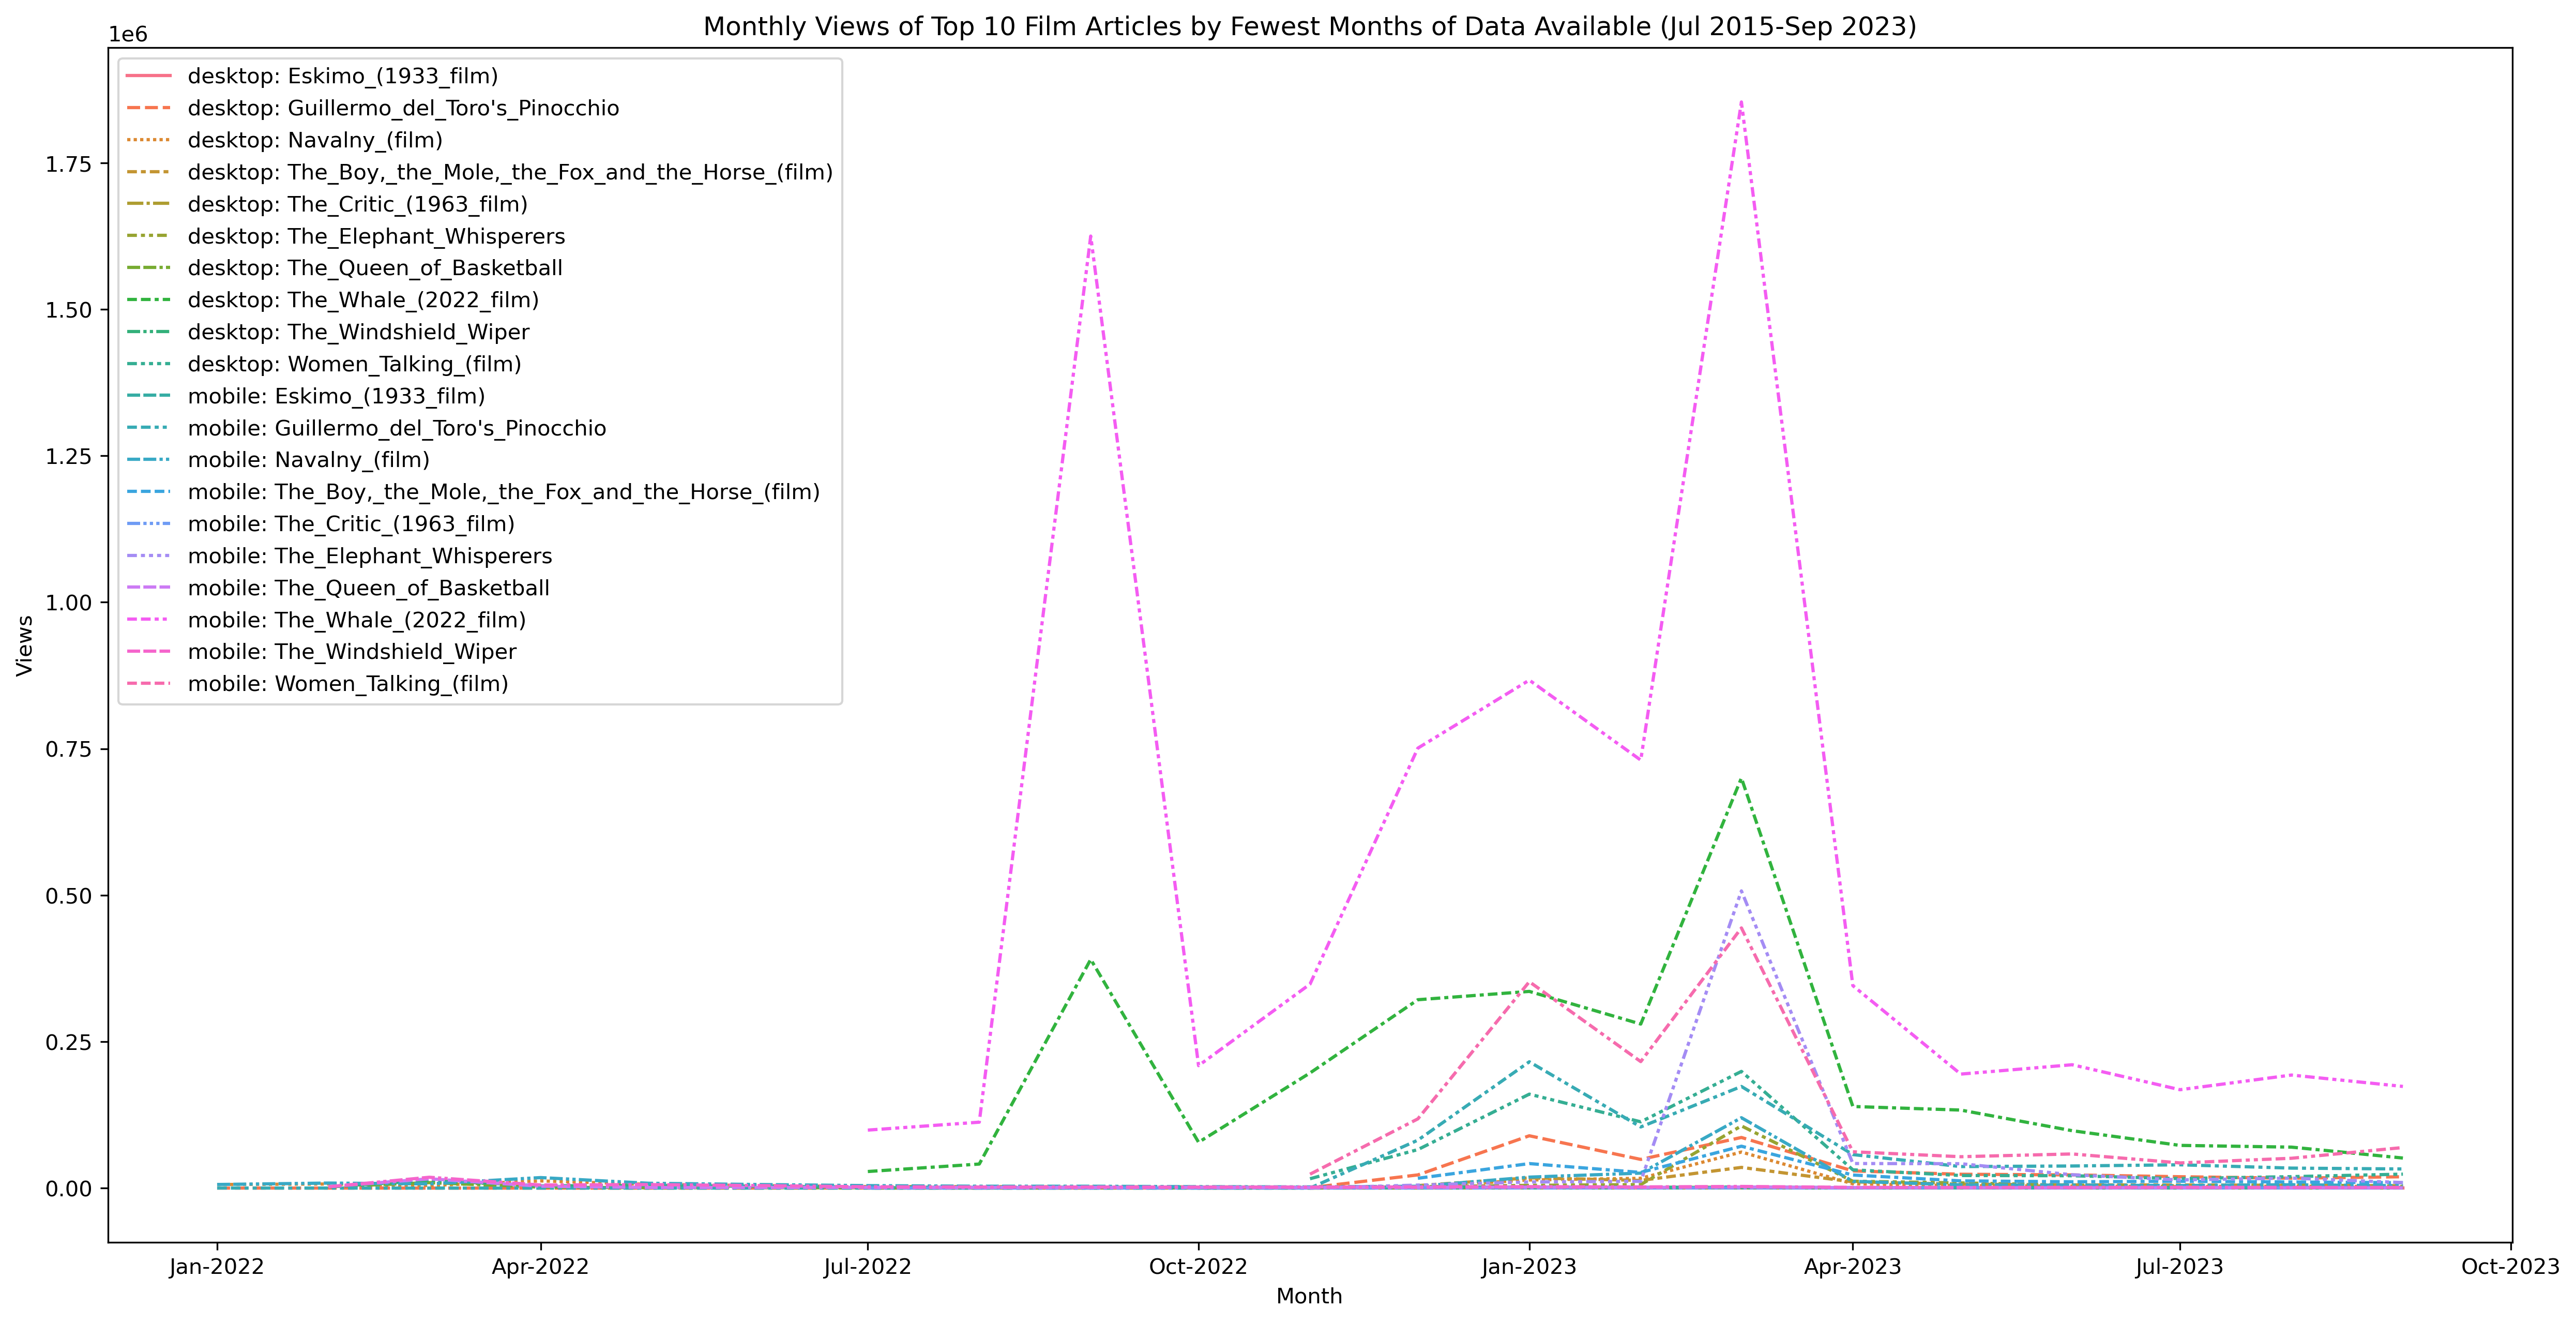

In [19]:
few_months_mobile = monthly_mobile.groupby('article')['timestamp'].count().reset_index()
few_months_mobile.sort_values('timestamp', ascending=True, inplace=True)
few_months_mobile = few_months_mobile.head(10)
top_10_few_mobile = monthly_mobile[
    monthly_mobile['article'].isin(few_months_mobile.article)].copy()
top_10_few_mobile['label'] = 'mobile'

few_months_desktop = monthly_desktop.groupby('article')['timestamp'].count().reset_index()
few_months_desktop.sort_values('timestamp', ascending=True, inplace=True)
few_months_desktop = few_months_desktop.head(10)
top_10_few_desktop = monthly_desktop[
    monthly_desktop['article'].isin(few_months_desktop.article)].copy()
top_10_few_desktop['label'] = 'desktop'

top_10_few = pd.concat([top_10_few_desktop, top_10_few_mobile])
top_10_few['month'] = top_10_few.timestamp.str[:8]
top_10_few['month'] = pd.to_datetime(top_10_few.month)
top_10_few['label'] = top_10_few['label'] + ': ' + top_10_few['article']
top_10_few.sort_values(['label'], inplace=True)

plt.figure(figsize=(20, 10), dpi=300)
sns.lineplot(data=top_10_few, x='month', y='views', hue='label', style='label')
date_format = mdates.DateFormatter('%b-%Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xlabel('Month')
plt.ylabel('Views')
plt.title('Monthly Views of Top 10 Film Articles by Fewest Months of Data Available (Jul 2015-Sep 2023)')
plt.legend(title='')
plt.savefig(os.path.join(WD, 'output/top_10_few.png'))

In [20]:
print(f'Elapsed time: {time.time() - start:.1f}')

Elapsed time: 695.5
